In this notebook, we compute $\lambda_{\rm loss}$ and $\lambda_{\rm error}$ as in Figure 9 of the paper.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.stats as stats
import sklearn.linear_model as linear_model
import tqdm

import gcmpyo3

In [23]:
def generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance):
    """
        It's still going to be with a logistic student
    """
    bound = 10.0
    teacher    = gcmpyo3.Probit(noise_variance = 0.0)
    student_Z0 = lambda y, omega : np.log(1 + np.exp(- y * omega))
    
    loss  = 0.0

    for y in [-1.0, 1.0]:
        tmp = integrate.quad(lambda xi : teacher.call_z0(y, m / np.sqrt(q) * xi, teacher_square_norm - m**2 / q + noise_variance) * student_Z0(y, np.sqrt(q) * xi) * stats.norm.pdf(xi, loc = 0.0, scale = 1.0), 
                               -bound, bound)
        loss  += tmp[0]

    return loss

def generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance):
    return 1. / np.pi * np.arccos(m / (np.sqrt(q * (teacher_square_norm + noise_variance))))

In [25]:
def find_lambda_loss(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        tolerance = 1e-4
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

def find_lambda_error(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        tolerance = 1e-4
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

In [58]:
def erm_logistic_regression(x, y, lambda_):
    max_iter = 10000
    tol      = 1e-20

    lr = linear_model.LogisticRegression(penalty='l2',solver='lbfgs',fit_intercept=False,
                                        C = (1. / lambda_), max_iter=max_iter, tol=tol, verbose=0)
    lr.fit(x, y)
    w = lr.coef_[0]
    return w

-- 

In [26]:
sampling_ratio_range = np.linspace(0.1, 20.0, 20)
noise_variance = 0.25 
teacher_square_norm = 1.0

In [27]:
lambda_loss_list = []
lambda_error_list = []

for sampling_ratio in tqdm.tqdm(sampling_ratio_range):
    lambda_loss_list.append( find_lambda_loss(sampling_ratio, noise_variance, teacher_square_norm) )
    lambda_error_list.append( find_lambda_error(sampling_ratio, noise_variance, teacher_square_norm) )

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


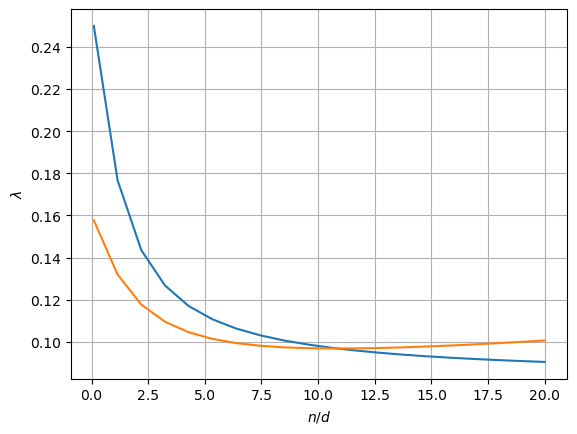

In [118]:
plt.plot(sampling_ratio_range, lambda_loss_list)
plt.plot(sampling_ratio_range, lambda_error_list)

plt.xlabel("$n/d$")
plt.ylabel("$\\lambda$")

plt.grid()

---

This part compares the experimental value of the loss / error with the theoretical prediction as a function of $\lambda$ to justify the use of the theoretically predicted $\lambda_{\rm loss}$ and $\lambda_{\rm error}$.

In [113]:
sampling_ratio = 2.0 
noise_variance = 0.25
lambda_range = np.linspace(0.01, 1.0, 50)
teacher_square_norm = 1.0

test_loss_lambda_list = []
test_error_lambda_list = []

# theoretical predictions 
for lambda_ in lambda_range:
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , 1e-15, False, False)
    test_loss_lambda_list.append( generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance) )
    test_error_lambda_list.append( generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance) )

Reached MAX_ITER_ERM in state evolution : last difference was 0.000000000000021760371282653068 / 0.000000000000001, relative tol. is false


In [114]:
# experimental predictions 
d = 2000
n = int(sampling_ratio * d)
n_test = 10000

wstar = np.random.normal(0.0, 1.0, d)
wstar = wstar / np.linalg.norm(wstar) * np.sqrt(d)
#
x = np.random.normal(0.0, 1.0, (n, d)) / np.sqrt(d)
y = np.sign(x @ wstar + np.sqrt(noise_variance) * np.random.normal(0.0, 1.0, n))
#
x_test= np.random.normal(0.0, 1.0, (n_test, d)) / np.sqrt(d)
y_test = np.sign(x_test @ wstar + np.sqrt(noise_variance) * np.random.normal(0.0, 1.0, n_test))

exp_test_loss_lambda_list = []
exp_test_error_lambda_list = []

for lambda_ in lambda_range:
    what = erm_logistic_regression(x, y, lambda_)
    m, q = np.mean(what * wstar), np.mean(what**2)
    test_loss = np.mean(np.log(1 + np.exp(- y_test * (x_test @ what))))
    exp_test_loss_lambda_list.append( test_loss )
    test_error = np.mean(np.sign(x_test @ what) != y_test)
    exp_test_error_lambda_list.append( test_error )


We observe the good agreement between the theory (state evolution equations) and the experiments

Text(0, 0.5, 'Test loss')

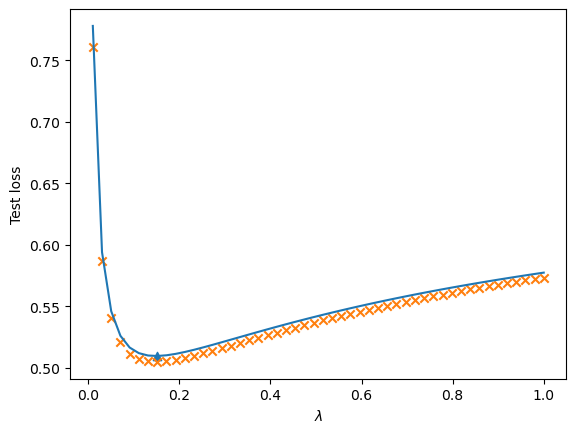

In [115]:
plt.plot(lambda_range, test_loss_lambda_list)
plt.scatter(lambda_range[np.argmin(test_loss_lambda_list)], np.min(test_loss_lambda_list), marker='^')
plt.scatter(lambda_range, exp_test_loss_lambda_list, marker='x')

plt.xlabel('$\\lambda$')
plt.ylabel('Test loss')

Text(0, 0.5, 'Test error')

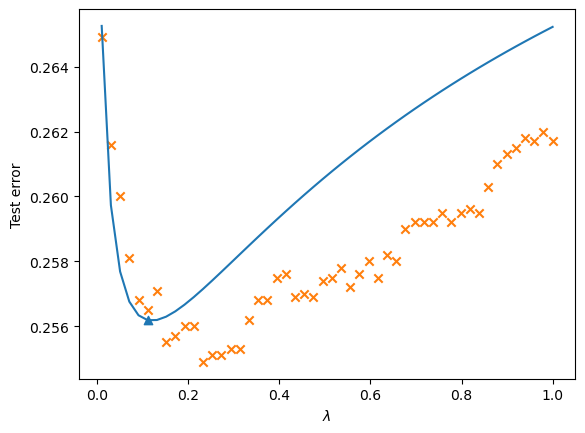

In [117]:
plt.plot(lambda_range, test_error_lambda_list)
plt.scatter(lambda_range[np.argmin(test_error_lambda_list)], np.min(test_error_lambda_list), marker='^')
plt.scatter(lambda_range, exp_test_error_lambda_list, marker='x')

plt.xlabel('$\\lambda$')
plt.ylabel('Test error')